In [1]:
import dowhy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [2]:
dataset = pd.read_csv('data/preprocessed_conflict_data_iter0MICE.csv')
dataset.drop(columns=[col for col in dataset.columns if\
                      (col.startswith("RTSM")&(col.endswith("No")))],
            inplace=True)
dataset["Roots_Mtgs"] = dataset[[col for col in dataset.columns if\
                      (col.startswith("RTSM"))]].sum(axis=1)
dataset.drop(columns=[col for col in dataset.columns if\
                      (col.startswith("RTSM"))],
            inplace=True)
dataset["Roots"] = np.where(dataset["Roots_Mtgs"]>0,1,0)
#dataset["AGEC_NEW"].fillna(dataset["AGEC_NEW"].median(),inplace=True)
dataset.head()

,Unnamed: 0.1,Unnamed: 0,SCHID,UID,ID,SCHTREAT_(1) Treatment school (Roots meetings 2012-2013),TREAT_(1) Treatment,TREAT_(2) Control,DE1,DE2,...,TOMERB_(1) Yes,TOMEMF_(1) Yes,TOMEPM_(1) Yes,TOMETHP_(1) Yes,TOMERE_(1) Yes,TOMESG_(1) Yes,TOMESU_(1) Yes,Baseline_Conflict_Score,Roots_Mtgs,Roots
0,0,0,1,100001,1,1,0,0,0,0,...,0,0,0,0,0,0,1,1.0,0,0
1,1,1,1,100002,2,1,0,1,0,0,...,0,0,0,0,0,0,0,1.0,0,0
2,2,2,1,100003,3,1,0,0,0,0,...,1,1,1,0,0,0,1,-3.0,0,0
3,3,3,1,100004,4,1,0,0,0,0,...,0,0,0,0,0,0,1,0.0,0,0
4,4,4,1,100005,5,1,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0,0


In [3]:
dataset["Roots"].value_counts()

0    22094
1      627
Name: Roots, dtype: int64

In [4]:
dataset.columns
dataset = dataset.drop(['Unnamed: 0'],axis=1)

<AxesSubplot:xlabel='Composite_Conflict_Score', ylabel='Density'>

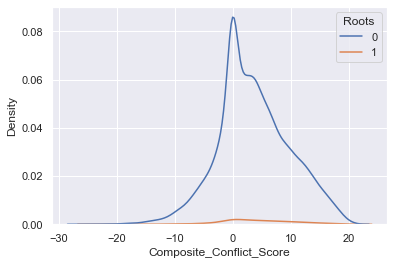

In [5]:
sns.kdeplot(data=dataset,x="Composite_Conflict_Score",hue="Roots")

Rename the columns for parsing causal graph (No number, space and brackets)

In [6]:
dataset = dataset.rename({"SCHTREAT_(1) Treatment school (Roots meetings 2012-2013)": "treatment_school",
"TREAT_(1) Treatment": "treatment_student",
"GENDER_(1) Boy": "is_boy",
"GR_(1) 6th grade":"sixth_grade",
"GR_(2) 7th grade":"seventh_grade",
"GR_(3) 8th grade":"eighth_grade",
"COLL_(1) Yes":"yes_college",
"COLL_(2) Maybe":"maybe_college",
"COLL_(3) Don't know":"not_sure_college",
"CELL_(1) Cell phone without Internet":"no_phone_internet",
"CELL_(2) Cell phone with Internet":"phone_internet",
"FSCH_(1) Do go to this school":"go_this_school"
},axis=1)
dataset.columns

Index(['Unnamed: 0.1', 'SCHID', 'UID', 'ID', 'treatment_school',
       'treatment_student', 'TREAT_(2) Control', 'DE1', 'DE2', 'DE3',
       ...
       'TOMERB_(1) Yes', 'TOMEMF_(1) Yes', 'TOMEPM_(1) Yes', 'TOMETHP_(1) Yes',
       'TOMERE_(1) Yes', 'TOMESG_(1) Yes', 'TOMESU_(1) Yes',
       'Baseline_Conflict_Score', 'Roots_Mtgs', 'Roots'],
      dtype='object', length=773)

## Causal Discovery Using PC Algorithm

Depth=7, working on node 14: 100%|██████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 879.81it/s]


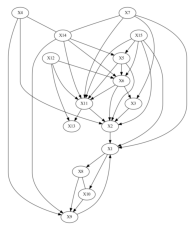

In [10]:
from causallearn.search.ConstraintBased.PC import pc

study_np = dataset[["Roots","AGEC_NEW",
                   "Composite_Conflict_Score","treatment_student","treatment_school",
                   "is_boy","go_this_school","phone_internet",
                    "sixth_grade","seventh_grade","eighth_grade",
                   "yes_college","maybe_college","not_sure_college",
                   "no_phone_internet","Baseline_Conflict_Score"]].to_numpy()
cg = pc(study_np[:,1:],verbose=False)

# visualization using pydot
cg.draw_pydot_graph()

The result doesn't make sense for our study. Let's build a graph manually.

In [8]:
dataset.columns

Index(['Unnamed: 0.1', 'SCHID', 'UID', 'ID', 'treatment_school',
       'treatment_student', 'TREAT_(2) Control', 'DE1', 'DE2', 'DE3',
       ...
       'TOMERB_(1) Yes', 'TOMEMF_(1) Yes', 'TOMEPM_(1) Yes', 'TOMETHP_(1) Yes',
       'TOMERE_(1) Yes', 'TOMESG_(1) Yes', 'TOMESU_(1) Yes',
       'Baseline_Conflict_Score', 'Roots_Mtgs', 'Roots'],
      dtype='object', length=773)

## Have a look on the correlation between treatment and outcome

Without treatment, the conflict level score is 3.629797682628768
With treatment, the conflict level score is 4.348086124401914


Text(0.5, 1.0, 'Scatter plot for Treatment Groups')

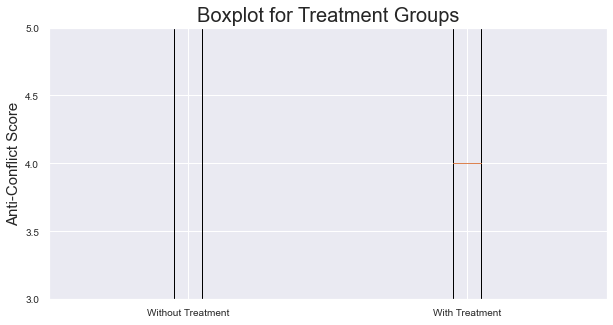

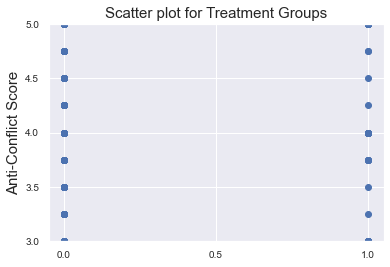

In [13]:
# Have a look on the average effect
import dowhy.datasets, dowhy.plotter

d0 = dataset[dataset.Roots == 0]
d0m = d0['Composite_Conflict_Score'].mean()
print('Without treatment, the conflict level score is',d0m)

d1 = dataset[dataset.Roots == 1]
d1m = d1['Composite_Conflict_Score'].mean()
print('With treatment, the conflict level score is',d1m)


plt.figure(figsize=(10,5))
plt.title('Boxplot for Treatment Groups',fontsize=20)
plt.ylim((3,5))
plt.ylabel('Anti-Conflict Score',fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
labels = ['Without Treatment','With Treatment']

plt.boxplot([d0['Composite_Conflict_Score'],d1['Composite_Conflict_Score']],widths=0.1,labels = labels)

plt.figure()
plt.ylim((3,5))
plt.ylabel('Anti-Conflict Score',fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.scatter(dataset.Roots,dataset['Composite_Conflict_Score'])
plt.title('Scatter plot for Treatment Groups',fontsize=15)
#dowhy.plotter.plot_treatment_outcome(dataset['treatment'],dataset['Composite_Conflict_Score'])

Our causal graph logic is:
1. Age may cause the grade, go to college decision, phone internet rate, go this school and conflict level
2. Boy ratio may cause the college decisioin and conflict level
3. Grades cause affect other and affect go to college decision, phone internet rate, go this school and conflict level
4. College decision affect each other and conflict score
5. Internet may affect the conflict level
6. Go to this school affect the satisification of the school thus conflict level.



In [ ]:
# This is a graph with circle, we should move later.
causal_graph = '''digraph{
    AGEC_NEW[label="Age"];
    treatment[label="Treatment"];
    boy_ratio[label="Boy Percentage"];
    sixth_grade[label="6th Grade Ratio"];
    seventh_grade[label="7th Grade Ratio"];
    eighth_grade[label="8th Grade Ratio"];
    yes_college[label="Go College Ratio"];
    maybe_college[label="Maybe Go College Ratio"];
    not_sure_college[label="Don't Know Go College Ratio"];
    no_phone_internet[label="Cell Phone Without Internet"];
    phone_internet[label="Cell Phone With Internet"];
    go_this_school[label="Do Go To This School Ratio"];
    Composite_Conflict_Score[label="Composite Conflict Score"];
    Roots[label="Roots"];
    treatment-> {Composite_Conflict_Score,Roots};
    AGEC_NEW -> {sixth_grade,seventh_grade,eighth_grade,yes_college,maybe_college,not_sure_college,no_phone_internet,phone_internet,go_this_school, Composite_Conflict_Score,Roots};
    boy_ratio -> {yes_college,maybe_college,not_sure_college,Composite_Conflict_Score,Roots};
    sixth_grade -> {seventh_grade,eighth_grade,yes_college,maybe_college,not_sure_college,no_phone_internet,phone_internet,go_this_school, Composite_Conflict_Score,Roots};
    seventh_grade -> {sixth_grade,eighth_grade,yes_college,maybe_college,not_sure_college,no_phone_internet,phone_internet,go_this_school, Composite_Conflict_Score,Roots};
    eighth_grade -> {sixth_grade,seventh_grade,yes_college,maybe_college,not_sure_college,no_phone_internet,phone_internet,go_this_school, Composite_Conflict_Score,Roots};
    yes_college -> {maybe_college,not_sure_college,Composite_Conflict_Score,Roots};
    maybe_college -> {yes_college,not_sure_college,Composite_Conflict_Score,Roots};
    not_sure_college -> {maybe_college,maybe_college,Composite_Conflict_Score,Roots};
    no_phone_internet -> {phone_internet, Composite_Conflict_Score,Roots};
    phone_internet -> {no_phone_internet, Composite_Conflict_Score,Roots};
    go_this_school-> {Composite_Conflict_Score,Roots};
    Roots -> {Composite_Conflict_Score}
}

'''

In [ ]:
causal_graph = '''digraph{
    AGEC_NEW[label="Age"];
    treatment[label="Treatment"];
    boy_ratio[label="Boy Percentage"];
    sixth_grade[label="6th Grade Ratio"];
    seventh_grade[label="7th Grade Ratio"];
    eighth_grade[label="8th Grade Ratio"];
    yes_college[label="Go College Ratio"];
    maybe_college[label="Maybe Go College Ratio"];
    not_sure_college[label="Don't Know Go College Ratio"];
    phone_internet[label="Cell Phone With Internet"];
    go_this_school[label="Do Go To This School Ratio"];
    Composite_Conflict_Score[label="Composite Conflict Score"][color=green];
    Roots[label="Roots"][color=blue];
    U[label="Unobserved Confounders"];
    treatment-> {Composite_Conflict_Score,Roots};
    AGEC_NEW -> {sixth_grade,seventh_grade,eighth_grade,yes_college,maybe_college,not_sure_college,no_phone_internet,phone_internet,go_this_school,Composite_Conflict_Score,Roots};
    boy_ratio -> {yes_college,maybe_college,not_sure_college,Composite_Conflict_Score,Roots};
    sixth_grade -> {yes_college,maybe_college,not_sure_college,no_phone_internet,phone_internet,go_this_school,Composite_Conflict_Score,Roots};
    seventh_grade -> {yes_college,maybe_college,not_sure_college,no_phone_internet,phone_internet,go_this_school,Composite_Conflict_Score,Roots};
    eighth_grade -> {yes_college,maybe_college,not_sure_college,no_phone_internet,phone_internet,go_this_school,Composite_Conflict_Score,Roots};
    yes_college -> {Composite_Conflict_Score,Roots};
    maybe_college -> {Composite_Conflict_Score,Roots};
    not_sure_college -> {Composite_Conflict_Score,Roots};
    phone_internet -> {no_phone_internet, Composite_Conflict_Score,Roots};
    go_this_school-> {Composite_Conflict_Score,Roots};
    Roots -> {Composite_Conflict_Score};
}

'''

In [14]:
causal_graph2 = '''digraph{
    AGEC_NEW[label="Age"];
    boy_ratio[label="Boy Percentage"];
    sixth_grade[label="6th Grade Ratio"];
    seventh_grade[label="7th Grade Ratio"];
    eighth_grade[label="8th Grade Ratio"];
    yes_college[label="Go College Ratio"];
    maybe_college[label="Maybe Go College Ratio"];
    not_sure_college[label="Don't Know Go College Ratio"];
    phone_internet[label="Cell Phone With Internet"];
    go_this_school[label="Do Go To This School Ratio"];
    Composite_Conflict_Score[label="Composite Conflict Score"][color=green];
    Baseline_Conflict_Score[label="Baseline Conflict Score"];
    treatment_school[label="Treatment School"]
    treatment_student[label="Treatment Student"]
    Roots[label="Roots"][color=blue];
    U[label="Unobserved Confounders"];
    AGEC_NEW -> {sixth_grade,seventh_grade,eighth_grade,yes_college,maybe_college,not_sure_college,no_phone_internet,phone_internet,go_this_school,Composite_Conflict_Score,Roots,Baseline_Conflict_Score};
    boy_ratio -> {yes_college,maybe_college,not_sure_college,Composite_Conflict_Score,Roots,Baseline_Conflict_Score};
    sixth_grade -> {yes_college,maybe_college,not_sure_college,no_phone_internet,phone_internet,go_this_school,Composite_Conflict_Score,Roots,Baseline_Conflict_Score};
    seventh_grade -> {yes_college,maybe_college,not_sure_college,no_phone_internet,phone_internet,go_this_school,Composite_Conflict_Score,Roots,Baseline_Conflict_Score};
    eighth_grade -> {yes_college,maybe_college,not_sure_college,no_phone_internet,phone_internet,go_this_school,Composite_Conflict_Score,Roots,Baseline_Conflict_Score};
    yes_college -> {Composite_Conflict_Score,Roots,Baseline_Conflict_Score};
    maybe_college -> {Composite_Conflict_Score,Roots,Baseline_Conflict_Score};
    not_sure_college -> {Composite_Conflict_Score,Roots,Baseline_Conflict_Score};
    phone_internet -> {Composite_Conflict_Score,Roots,Baseline_Conflict_Score};
    go_this_school-> {Composite_Conflict_Score,Roots,Baseline_Conflict_Score};
    Roots -> {Composite_Conflict_Score};
    treatment_school -> treatment_student;
    treatment_student -> Roots;
    Baseline_Conflict_Score -> Roots, Composite_Conflict_Score;
}
'''

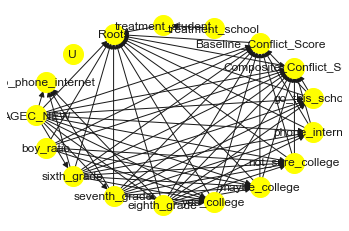

In [15]:
model= dowhy.CausalModel(
        data = dataset,
        graph=causal_graph2.replace("\n", " ").replace(",",";"),
        treatment='Roots',
        outcome='Composite_Conflict_Score')
model.view_model()
#from IPython.display import Image, display
#display(Image(filename="causal_model.png"))

# Identify the causal effect

In [16]:
#Identify the causal effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=False)
print(identified_estimand)

KeyboardInterrupt: 

## Linear regression for backdoor estimator

In [ ]:
estimate = model.estimate_effect(identified_estimand, 
                                 method_name="backdoor.linear_regression",target_units="ate",
                                test_significance="bootstrap")
# ATE = Average Treatment Effect
# ATT = Average Treatment Effect on Treated (i.e. those who were assigned a different room)
# ATC = Average Treatment Effect on Control (i.e. those who were not assigned a different room)
print(estimate)

In [ ]:
model.summary()

In [ ]:
# Plot Slope of line between action and outcome = causal effect
dowhy.plotter.plot_causal_effect(estimate, dataset["Roots"], dataset["Composite_Conflict_Score"])

In [ ]:
refute1_results=model.refute_estimate(identified_estimand, estimate,
        method_name="random_common_cause")
print(refute1_results)

In [ ]:
refute2_results=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter")
print(refute2_results)

In [ ]:
refute3_results=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter")
print(refute3_results)

## Double Machine Learning Method

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
import econml

In [ ]:
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False),
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=False)},
                                               "fit_params":{}})
print(dml_estimate)

In [ ]:
refute1_results=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="random_common_cause")
print(refute1_results)

In [ ]:
refute2_results=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="placebo_treatment_refuter")
print(refute2_results)

In [ ]:
refute3_results=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="data_subset_refuter")
print(refute3_results)